In [400]:
import numpy as np
from utils.database_repository import DataRepository
from utils.objects import *
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import time
from datetime import datetime
import inspect
from utils.constants import *
from datetime import datetime
import math
import statistics
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from pathlib import Path


In [401]:
# %store data

In [402]:
%store -r

In [403]:
# repository = DataRepository()

# data = repository.get_experiments(
#         duts,
#         oses,
#         test_cases,
#         profilers,
#         dut_version,
#         min_temp,
#         max_temp,
#         min_battery,
#         max_battery,
#         duration,
#         between,
#         env,
#         language,
#         special_between
#     )

# repository.close()


np.percentile(arr, 50)
statistics.median(items)

In [404]:
# for d in duts:
#             for o in os:
#                 for t in test_cases:
#                     for p in profilers:
#                         if o in special_between and p in special_between[o]:
#                             version = special_between[o][p]
#                         else:
#                             version = dut_version[d][o]
                        
#                         exp = data[d][o][t][p]
                        
#                         k = exp.k
#                         points_to_look_back = exp.points_to_look_back
                        
#                         outliers = find_outliers(exp["experiment"], k, points_to_look_back, p, 1, 0, 0, 1, False, False, min_sampels=4, show_graphs=False)
                        
#                         for e in exp["experiment"]:
#                             if e.id in outliers:
#                                 e.is_outlier = True
#                             else:
#                                 e.is_outlier = False
                        
                        

### Configuration

The configuration defines under what circumstances the experiment was executed under.

In [405]:
# CONFIGURATION
min_temp = 0
max_temp = 200

min_battery = 40
max_battery = 80

between = 0
duration = 1

special_between = {
    WINDOWS_OS : {
        CLAMP : 1
    }
}

language = "CSharp"

env = "PROD"

limit = 200

### Operating System

Here the different operation systems used in the experiments are defined

In [406]:
## OS
oses = [
    WINDOWS_OS,
    LINUX_OS
]

short_os = {
    WINDOWS_OS : "win",
    LINUX_OS : "lin"
}

### Test Cases

Here the different test cases executed during the experiments are defined

In [407]:
## Test cases
test_cases = [
    IDLE_CASE,
    # DINING_PHILOSOPHERS,
    BINARY_TREE,
    # REVERSE_COMPLEMENT
    FANNKUCH_REDUX,
    NBODY,
    FASTA
]

short_test_case = {
    IDLE_CASE : "idle",
    DINING_PHILOSOPHERS : "din",
    BINARY_TREE : "bin",
    REVERSE_COMPLEMENT : "rev",
    FANNKUCH_REDUX : "fann",
    NBODY : "nbody",
    FASTA : "fasta"
}

### Profilers

Here the different profilers used to measure the energy consumption of the test cases are defined

In [408]:
## Profilers
profilers = [
    INTEL_POWER_GADGET,
    RAPL,
    HARDWARE_MONITOR,
    CLAMP,
    E3
]

short_profilers = {
    INTEL_POWER_GADGET : "IPG",
    RAPL : "RA",
    HARDWARE_MONITOR : "HWM",
    E3 : "E3",
    CLAMP : "CL"
}

### DUT

Here the different Devices Under Tests (DUT) are defined

In [409]:
## DUT
duts = [
    SURFACE_4_PRO,
    SURFACE_BOOK,
    POWER_KOMPLETT
]

short_duts = {
    SURFACE_4_PRO : "pro",
    SURFACE_BOOK : "book",
    POWER_KOMPLETT : "pow",
}

dut_version = {
    SURFACE_BOOK : {
            WINDOWS_OS : 6,
            LINUX_OS : 3
        },
    SURFACE_4_PRO : {
        WINDOWS_OS : 12,
        LINUX_OS : 2,
    },
    POWER_KOMPLETT : {
        WINDOWS_OS : 8,
        LINUX_OS : 1,
    }
}

### Types

Here the different types of energy measurements are defined

In [410]:
## Types
comparison_types = [PACKAGE_TOTAL, DRAM_TOTAL,CORE_TOTAL]


In [411]:
def find_outliers(experiments, k, points_to_look_back, profiler, y_max, y_min, x_min, x_max, use_x_lim, use_y_lim, min_sampels=4, show_graphs=False):
    exp_data_points = [] #here 
    k = 1

    for e in experiments:
        if profiler == INTEL_POWER_GADGET:
            power = e.CumulativeProcessorEnergyInJoules
        elif profiler == HARDWARE_MONITOR:
            power = e.cpuPowerPacketTotalJ
        elif profiler == RAPL:
            power = e.CoreStopInJoules - e.CoreStartInJoules
        elif profiler == CLAMP:
            power = e.TrueRMS
        else:
            raise Exception("profiler not implemented") ## ipg CumulativeProcessorEnergyInJoules, TrueRMS, x.CoreStopInJoules - x.CoreStartInJoules
        
        exp_data_points.append(ExpDataPoint(
            e.id, power, e.runs, e.duration
        ))
    
    # if show_graphs:
    #     plt.scatter(*zip(*(x.get_tuple() for x in exp_data_points)))
    #     plt.show()
    
    for p1 in exp_data_points:
        dists = []
        for p2 in exp_data_points:
            if p1.exp_id == p2.exp_id:
                dists.append(math.inf)
            else:
                dists.append(math.dist(p1.get_tuple(), p2.get_tuple()))
        sorted_by_second = sorted(dists, key=lambda tup: tup)
        p1.set_distance_to_k(sorted_by_second[k])
    
    exp_data_points = sorted(exp_data_points, key=lambda tup: tup.dist)
    
    for i in range(len(exp_data_points)):
        exp_data_points[i].set_id(i)

    if show_graphs:
        plt.scatter(*zip(*((x.id, x.dist) for x in exp_data_points)))

        plt.show()
    
    eps = exp_data_points[-points_to_look_back].dist
    min_sampels = 4
    
    data_arr = np.array([x.get_tuple() for x in exp_data_points])
    
    dbscan = DBSCAN(eps = eps, min_samples = min_sampels)
    pred = dbscan.fit_predict(data_arr)
    anom_index = np.where(pred == -1)
    values = data_arr[anom_index]

    if show_graphs:
        plt.scatter(data_arr[:,0], data_arr[:,1])
        plt.scatter(values[:,0], values[:,1], color='r')
        if use_x_lim:
            plt.xlim(x_min, x_max)
        if use_y_lim:
            plt.ylim(y_min,y_max)
        plt.show()

    points_to_remove = []

    for v in values:
        for e in exp_data_points:
            tup = (v[0], v[1])
            
            if tup == e.get_tuple():
                points_to_remove.append(e)
                break

    print(f"{len(points_to_remove)} points were removed")
                
    # for p in points_to_remove:
    #     print(f"{p.exp_id} - {p.get_tuple()}")
    
    return [x.exp_id for x in points_to_remove]
    

In [412]:
# def get_dynamic_energy(
#     d, o, p, energy_type, duration, energy_consumption, dynamic_energy, per_unit=1000
# ):
#     dynamic_energy_index = dynamic_energy[d][o][p]

#     dynamic_energy_consumption = dynamic_energy_index[energy_type]
#     dynamic_duration = dynamic_energy_index["duration"]

#     if dynamic_duration == 0 or duration == 0:
#         return 0

#     dynamic_energy_per_unit = (per_unit / dynamic_duration) * dynamic_energy_consumption
#     energy_per_unit = (per_unit / duration) * energy_consumption

#     return energy_per_unit - dynamic_energy_per_unit

In [413]:
def default_func(exp, value):
    return True


def get_consumption(
    d,
    o,
    p,
    t,
    value_type,
    func_parameter,
    data,
    dynamic_energy,
    func=default_func,
    get_dynamic=True,
    include_outliers = False
):
    try:
        data_points = data[d][o][t][p]["experiment"].experiments
    except Exception as e:
        return 0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0, 0
    
    if not include_outliers:
        data_points = [x for x in data_points if not x.is_outlier]

    # duration = [
    #     exp.duration / exp.runs for exp in data_points if func(exp, func_parameter)
    # ]

    duration_list = [x.duration for x in data_points if func(x, func_parameter)]
    runs_list = [x.runs for x in data_points if func(x, func_parameter)]

    if len(duration_list) > 0:
        avg_dur = sum(duration_list) / len(duration_list)
    else:
        avg_dur = 0
    
    if len(runs_list) > 0:
        avg_run = sum(runs_list) / len(runs_list)
    else:
        avg_run = 0

    length = len(duration_list)

    if value_type == PACKAGE_TOTAL:
        if p == INTEL_POWER_GADGET:
            values = [
                (x.CumulativeProcessorEnergyInJoules, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == CLAMP:
            values = [(x.TrueRMS, x.duration) for x in data_points]
        elif p == HARDWARE_MONITOR:
            values = [
                (x.cpuPowerPacketTotalJ, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == RAPL:
            values = [
                (x.PSysStopInJoules - x.PSysStartInJoules, x.duration) for x in data_points if func(x, func_parameter)
            ]
        else:
            raise Exception(f"{p} not implemented")
    elif value_type == DRAM_TOTAL:
        if p == INTEL_POWER_GADGET:
            values = [
                (x.CumulativeDramEnergyInJoules, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == CLAMP:
            values = [(0, 0) for x in data_points]
        elif p == HARDWARE_MONITOR:
            values = [
                (x.cpuPowerMemoryTotalJ, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == RAPL:
            values = [
                (x.DramStopInJoules - x.DramStartInJoules, x.duration) for x in data_points if func(x, func_parameter)
            ]
        else:
            raise Exception(f"{p} not implemented")
    elif value_type == CORE_TOTAL:
        if p == INTEL_POWER_GADGET:
            values = [
                (x.CumulativeProcessorEnergyInJoules, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == CLAMP:
            values = [
                (x.TrueRMS, x.duration) for x in data_points if func(x, func_parameter)
            ]
        elif p == HARDWARE_MONITOR:
            values = [
                (x.cpuPowerCoresTotalJ, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == RAPL:
            values = [
                (x.CoreStopInJoules - x.CoreStartInJoules, x.duration) for x in data_points if func(x, func_parameter)
            ]
        else:
            raise Exception(f"{p} not implemented")
    else:
        raise Exception(f"{value_type} not implmeneted")

    if get_dynamic:
        if length == 0:
            return 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
        
        only_values = [x[0] / avg_run for x in values]
        avg_value = sum(only_values) / len(only_values)
        
        dyn_val = []
        
        for v in only_values:
            dyn = get_dynamic_energy(d, o, p, value_type, v, dynamic_energy, avg_run, avg_dur)
            dyn_val.append(dyn)

        return (
            length,
            sum(dyn_val) / len(dyn_val),
            np.std(dyn_val),
            min(dyn_val),
            max(dyn_val),
            avg_dur,
            avg_run,
            0,
            np.percentile(dyn_val, 25),
            np.percentile(dyn_val, 75),
            statistics.median(dyn_val),
            dyn_val
        )
    else:
        only_values = [x[0] / avg_run for x in values]
        
        avg_value = sum(only_values) / len(only_values)
        
        # value_for_one_sec = avg_value * (1000 / (avg_dur / avg_run))
        
        values_for_one_sec = [x * (1000 / (avg_dur / avg_run)) for x in only_values]
        
        value_for_one_sec = sum(values_for_one_sec) / len(values_for_one_sec)
        
        return (
            length,
            avg_value,
            np.std(values_for_one_sec),
            min(values_for_one_sec),
            max(values_for_one_sec),
            avg_dur,
            avg_run,
            value_for_one_sec,
            np.percentile(values_for_one_sec, 25),
            np.percentile(values_for_one_sec, 75),
            statistics.median(values_for_one_sec),
            only_values
        )

In [414]:
def initialize_dynamic_energy(data, used_profilers = profilers):
    dynamic_energy = {}
    for d in duts:
        dynamic_energy[d] = {}
        for o in oses:
            dynamic_energy[d][o] = {}
            for p in used_profilers:
                dynamic_energy[d][o][p] = {}
                for types in comparison_types:
                    t = IDLE_CASE
                    
                    count, average, _, min_value, max_value, avg_dur, avg_run, _, _, _, _, _ = get_consumption(
                        d, o, p, t, types, "", data, dynamic_energy, get_dynamic=False)
                    dynamic_energy[d][o][p][types] = average
                    dynamic_energy[d][o][p]["avg_dur"] = avg_dur
                    dynamic_energy[d][o][p]["avg_run"] = avg_run
    return dynamic_energy

In [415]:
def is_correct_first_profiler(exp, value):
    return exp.first_profiler == value

def plot_first_profiler_comparison(comparison_type, data, dynamic_energy, xlabel, ylabel, label, ylim_max=100):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    x = []
    y = []
    e = []

    i = 0

    for d in duts:
        for t in test_cases:
            if t != IDLE_CASE:
                for o in oses:
                    for p in profilers:
                        for first_profiler in profilers:
                            length, average, std, min_value, max_value, _, _, _, _, _, _, _ = get_consumption(d, o, p, t, comparison_type, first_profiler, data, dynamic_energy, func=is_correct_first_profiler)
                            
                            if not min_value == 0 and not max_value == 0:
                                x.append(f"{short_os[o]} {short_duts[d]} {short_profilers[p]} {short_test_case[t]}")
                                y.append(average)
                                e.append(std)
                                
                                # print(f"{i} - {first_profiler}, {p}, {d}, {o}, {t} - sum of {length} ({min_value} - {max_value})")
                                # print(f"{i} - {d}, {t}, {o}, {p}, {first_profiler} - sum of {length} ({min_value} - {max_value})")
                                i += 1

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(label)
    ax = plt.gca()
    ax.tick_params(axis='x', labelrotation = 90)
    plt.errorbar(x, y, e, linestyle='None', marker='.')
    plt.ylim(0,ylim_max)
    plt.show()

In [416]:
def plot_comparison(comparison_type, data, dynamic_energy, xlabel, ylabel, label, ylim_max=100, get_dynamic=True, used_test_cases = test_cases, include_idle = False, plot_graph=True, used_profilers=profilers, include_outliers=False):
    
    if plot_graph:
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])

    x = []
    y = []
    e = []
    
    perc25 = []
    perc75 = []
    low_whiskey = []
    high_whiskey = []
    median = []
    names = []
    all_values = []
    other_names = []


    i = 0

    for t in used_test_cases:
        if include_idle or t != IDLE_CASE:
            for d in duts:
                for o in oses:
                    for p in used_profilers:
                        if (p == CLAMP and d == POWER_KOMPLETT) or p != CLAMP:
                            length, average, std, min_value, max_value, _, _, val_for_one_sec, p25, p75, m, values = get_consumption(d, o, p, t, comparison_type, "", data, dynamic_energy, get_dynamic=get_dynamic, include_outliers=include_outliers)
                            
                            if length > 0:
                                if plot_graph:
                                    x.append(f"{short_os[o]} {short_duts[d]} {short_profilers[p]} {short_test_case[t]}")
                                    e.append(std)
                                    if get_dynamic:
                                        y.append(average)
                                    else:
                                        y.append(val_for_one_sec)
                                
                                perc25.append(p25)
                                perc75.append(p75)
                                low_whiskey.append(min_value)
                                high_whiskey.append(max_value)
                                median.append(m)
                                all_values.append(values)
                                
                                used_dut_name = "workstation" if d == POWER_KOMPLETT else d
                                
                                
                                if p == CLAMP:
                                    names.append(f"{used_dut_name} - {p} ({short_os[o]})")
                                    other_names.append(f"{t} - {used_dut_name} - {p} ({short_os[o]})")
                                else:
                                    names.append(f"{used_dut_name} - {p}")
                                    other_names.append(f"{t} - {used_dut_name} - {p}")
                                # names.append(f"{}")
                                # names.append(f"{short_os[o]} {short_duts[d]} {short_profilers[p]} {short_test_case[t]}")
                                
                                i += 1

    if plot_graph:
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(label)
        plt.errorbar(x, y, e, linestyle='None', marker='.')
        ax.tick_params(axis='x', labelrotation = 90)
        plt.ylim(0,ylim_max)
        
        plt.show()
    
    return perc25, perc75, low_whiskey, high_whiskey, median, names, all_values, other_names

In [417]:
def plot_iterations(comparison_type, get_next_value, is_correct_value, xlabel, ylabel, label, data, dynamic_energy, used_duts = duts, used_test_cases = test_cases, plot_graph=True, get_dynamic=True, include_outliers=False):
    if plot_graph:
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
    
    x_lines = []
    y_lines = []
    name_lines = []
    
    print(used_test_cases)
    for d in used_duts:
        for t in used_test_cases:
            if t != IDLE_CASE:
                for o in oses:
                    for p in profilers:
                        if (p == CLAMP and d == POWER_KOMPLETT) or p != CLAMP:
                            x1 = []
                            y1 = []
                            avg_len = []
                            for i in get_next_value():
                                length, average, _, min_value, max_value, _, _, _, _, _, _, _ = get_consumption(d, o, p, t, comparison_type, i, data, dynamic_energy, func=is_correct_value, get_dynamic=get_dynamic, include_outliers=include_outliers)
                                
                                if length > 0:
                                    avg_len.append(length)
                                    if isinstance(i, tuple) or isinstance(i, list):
                                        x1.append(i[0])
                                    else:
                                        x1.append(i)
                                    y1.append(average)
                            if len(x1) > 0:
                                print(f"{d} - {t} - {o} - {p} - avg {sum(avg_len) / len(avg_len)} ({min(avg_len)}, {max(avg_len)})")
                                if plot_graph:
                                    plt.plot(x1, y1, label = f"{short_os[o]} {short_duts[d]} {short_profilers[p]} {short_test_case[t]}")
                                x_lines.append(x1)
                                y_lines.append(y1)
                                
                                used_dut_name = "workstation" if d == POWER_KOMPLETT else d
                                if p == CLAMP:
                                    name_lines.append(f"{used_dut_name} - {p} ({short_os[o]})")
                                else:
                                    name_lines.append(f"{used_dut_name} - {p}")
                                
    if plot_graph:
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(label)
        plt.legend()
        plt.show()
    return x_lines, y_lines, name_lines

### Datainitialization

The data for the experiments will be fetched from the database and stored in a dictionary, in the order as can be seen below:

```python
data[current_dut][current_os][current_test_case][current_profiler]
```

In [418]:
# exp = data[SURFACE_4_PRO][LINUX_OS][BINARY_TREE][RAPL]["experiment"].experiments[0]
# inspect.getmembers(exp, lambda a:not(inspect.isroutine(a)))

In [419]:
data[SURFACE_4_PRO][WINDOWS_OS][IDLE_CASE][INTEL_POWER_GADGET]["contains_data"] #here
# ee.k, ee.look_back

True

In [420]:
for d in duts: #here
    for o in oses:
        for t in test_cases:
            for p in profilers:
                if data[d][o][t][p]["contains_data"]:
                    ee = data[d][o][t][p]["experiment"]
                    removed_points = find_outliers(ee.experiments, ee.k, ee.look_back, p, 0, 0, 0, 0, False, False, min_sampels=4, show_graphs=False)
                    
                    for e in ee.experiments:
                        if e.id in removed_points:
                            e.is_outlier = True
                        else:
                            e.is_outlier = False




3 points were removed
3 points were removed
4 points were removed
4 points were removed
1 points were removed
1 points were removed
1 points were removed
1 points were removed
3 points were removed
1 points were removed
2 points were removed
4 points were removed
6 points were removed
6 points were removed
4 points were removed
1 points were removed
4 points were removed
1 points were removed
4 points were removed
4 points were removed
6 points were removed
3 points were removed
5 points were removed
1 points were removed
4 points were removed
6 points were removed
3 points were removed
4 points were removed
1 points were removed
2 points were removed
6 points were removed
3 points were removed
2 points were removed
3 points were removed
2 points were removed
1 points were removed
6 points were removed
4 points were removed
7 points were removed
3 points were removed
9 points were removed
2 points were removed
2 points were removed
3 points were removed
6 points were removed
7 points w

In [421]:
ee.experiments[0].id, ee.experiments[0].is_outlier 

(10846, False)

### Dynamic Energy

Next up, the dynamic energy will be calculated. This will be the average energy consumption of the idle case.

In [422]:
dynamic_energy = initialize_dynamic_energy(data)
dynamic_energy.keys()

dict_keys(['Surface4Pro', 'SurfaceBook', 'PowerKomplett'])

### Dynamic Energy Example

An example of how the dynamic energy consumption is calculated can be seen below.

In [423]:
def get_dynamic_energy(d, o, p, energy_type, energy_consumption, dynamic_energy, avg_run, avg_dur, per_unit=1000):
    dynamic_energy_index = dynamic_energy[d][o][p]

    dynamic_energy_consumption = dynamic_energy_index[energy_type]
    dyn_avg_dur = dynamic_energy_index["avg_dur"]
    dyn_avg_run = dynamic_energy_index["avg_run"]
    
    if dyn_avg_dur == 0 or dyn_avg_run == 0:
        return 0
    
    dynamic_energy_per_unit = dynamic_energy_consumption * (per_unit / (dyn_avg_dur / dyn_avg_run))
    energy_per_unit = energy_consumption * (per_unit / (avg_dur / avg_run))
    
    return energy_per_unit - dynamic_energy_per_unit 

In [424]:
dynamic_energy_dut = SURFACE_4_PRO
dynamic_energy_os = WINDOWS_OS
dynamic_energy_profiler = INTEL_POWER_GADGET
dynamic_energy_test_case = NBODY
dynamic_energy_type = CORE_TOTAL

In [425]:
length, energy_consumption, _, _, _, avg_dur, avg_run, energy_consumption_per_sec, perc25, perc75, _, _ = get_consumption(dynamic_energy_dut, 
                                                            dynamic_energy_os, 
                                                            dynamic_energy_profiler, 
                                                            dynamic_energy_test_case, 
                                                            dynamic_energy_type, "", 
                                                            data,
                                                            dynamic_energy, 
                                                            get_dynamic=False,
                                                            include_outliers=False)

dynamic_energy_consumption = get_dynamic_energy(dynamic_energy_dut, 
                                                dynamic_energy_os, 
                                                dynamic_energy_profiler, 
                                                dynamic_energy_type, 
                                                energy_consumption,
                                                dynamic_energy, 
                                                avg_run, 
                                                avg_dur,
                                                per_unit=avg_dur/avg_run)
# dynamic_energy_consumption = get_dynamic_energy(d, v, o, p, dynamic_energy_type, duration, energy_consumption, per_unit=0.5716669904816651)



# energy_consumption, energy_consumption_per_sec, dynamic_energy_consumption, avg_dur/avg_run
length

119

In [426]:
# data_to_inspect = data[power_komplett][windows_os][idle_case][intel_power_gadget]["experiment"].experiments[0].start_battery.data
# inspect.getmembers(data_to_inspect, lambda a:not(inspect.isroutine(a)))

### Intel Power Gadget

- CumulativeDramEnergyInJoules
- CumulativeGtEnergyInJoules
- CumulativeIaEnergyInJoules
- CumulativeProcessorEnergyInJoules

### Clamp

- TrueRMS
- ACRMSRAW

idle -  true: 3651, acr: 3612
fans - 600 - 700

### OpenHardwareMonitor

- cpuPowerPacketTotalJ
- cpuPowerCoresTotalJ
- cpuPowerMemoryTotalJ
- cpuPowerPacketAverageJ
- cpuPowerCoresAverageJ
- cpuPowerMemoryAverageJ

### Dynamic energy consumption

A graph comparing the package measuring made by different measuring instruments on the different DUTs

In [427]:
# plot_comparison(PACKAGE_TOTAL, data, dynamic_energy, "Package total DUT", "joules in a second", "average package energy consumption in joules for DUTs")


### Dynamic energy consumption

A graph comparing the dram measuring made by different measuring instruments on the different DUTs

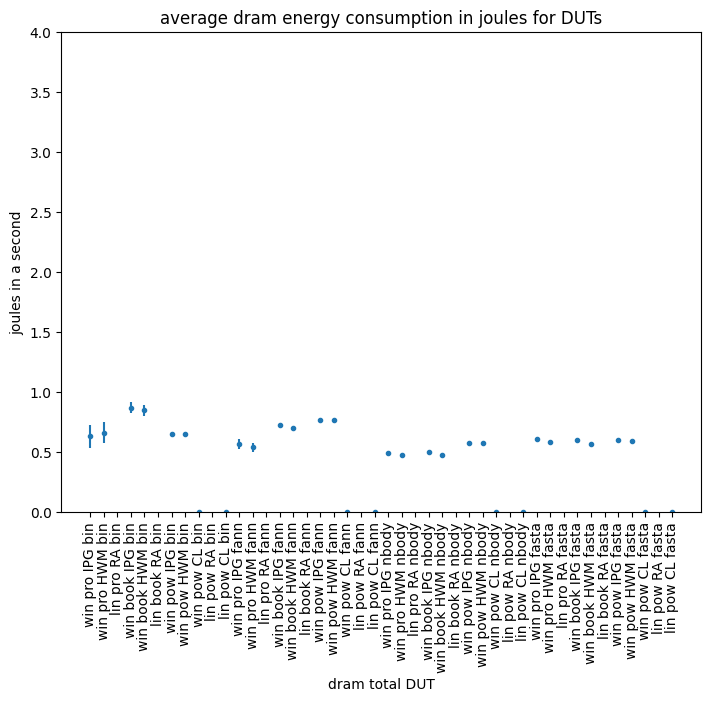

([0.5562680103103179,
  0.6244930500069773,
  89.97597016456282,
  0.8370672204045941,
  0.808999511424044,
  31.78389845095991,
  0.6460088454063434,
  0.639713879856104,
  0.0,
  927.1691250071984,
  0.0,
  0.5201298210473831,
  0.5037561170740252,
  91.81266533744872,
  0.7225038674497488,
  0.6943211732707849,
  37.09291735608336,
  0.7616969702740483,
  0.7608850945114618,
  0.0,
  847.1311074056259,
  0.0,
  0.4956347199244173,
  0.4766960904973687,
  82.4679233959217,
  0.5000103487856075,
  0.4743884422468024,
  31.64964254474365,
  0.5790707029232778,
  0.577754848512829,
  0.0,
  501.6389029766875,
  0.0,
  0.6055793884842232,
  0.5777607070634109,
  88.56080134945978,
  0.5924561542607306,
  0.5618739902862893,
  34.50776080441142,
  0.5978523607378348,
  0.5939672597075659,
  0.0,
  609.4979070855738,
  0.0],
 [0.7092981696523639,
  0.7264843891778738,
  263.5022169357119,
  0.9054965553486068,
  0.8817529860744937,
  100.05298969017821,
  0.6625072296043609,
  0.6536033520

In [428]:
plot_comparison(DRAM_TOTAL,
                data,
                dynamic_energy,
                "dram total DUT",
                "joules in a second",
                "average dram energy consumption in joules for DUTs",
                get_dynamic=False,
                ylim_max=4)

### Dynamic energy consumption

A graph comparing the core measuring made by different measuring instruments on the different DUTs

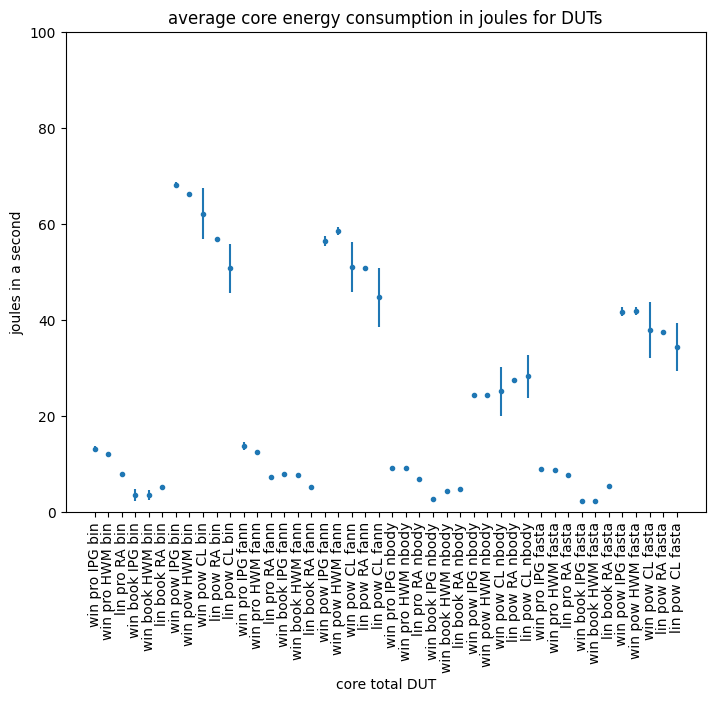

(1.7456562313649844, 74.07463632358858)

In [429]:
perc25, perc75, low_whiskey, high_whiskey, median, names, all_values, other_names = plot_comparison(CORE_TOTAL, data, dynamic_energy, "core total DUT", "joules in a second", "average core energy consumption in joules for DUTs", ylim_max=100, get_dynamic=True, include_outliers=False)
min(low_whiskey), max(high_whiskey)

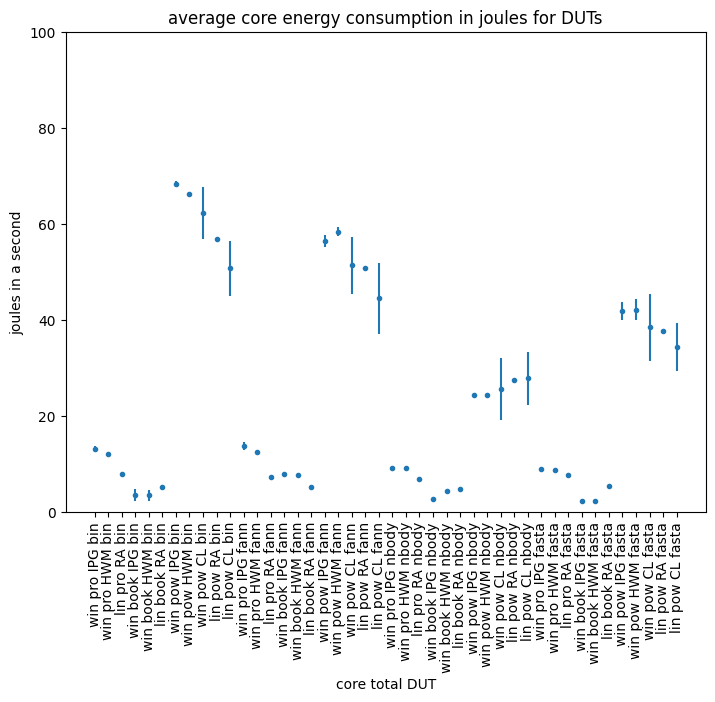

(1.3654690702402312, 76.59487529684452)

In [430]:
perc25, perc75, low_whiskey, high_whiskey, median, names, all_values, other_names = plot_comparison(CORE_TOTAL, data, dynamic_energy, "core total DUT", "joules in a second", "average core energy consumption in joules for DUTs", ylim_max=100, get_dynamic=True, include_outliers=True)
min(low_whiskey), max(high_whiskey)

In [431]:
# plot_comparison(CORE_TOTAL, data, dynamic_energy, "core total DUT", "joules in a second", "average core energy consumption in joules for DUTs", ylim_max=10, get_dynamic=False)


In [432]:
# used_test_cases = [IDLE_CASE, FASTA]

# plot_comparison(CORE_TOTAL, data, dynamic_energy, "core total DUT", "joules in a second", "average core energy consumption in joules for DUTs", ylim_max=100, get_dynamic=True, include_idle=False)
# plot_comparison(CORE_TOTAL, data, dynamic_energy, "core total DUT", "joules in a second", "average core energy consumption in joules for DUTs", ylim_max=100)



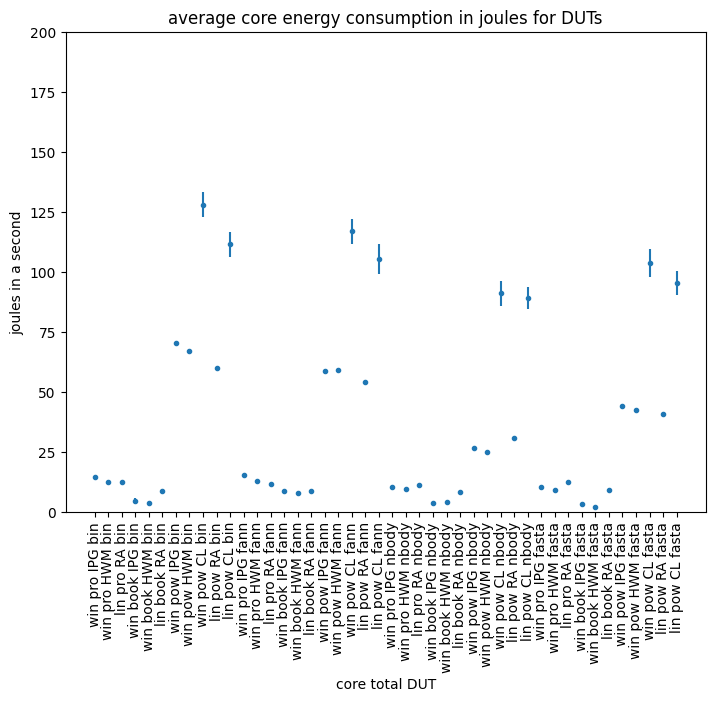

([14.14810962621224,
  12.299553425399857,
  12.643574889169882,
  3.668120567871115,
  2.589990418347309,
  8.62780876091933,
  70.19268894870973,
  66.94006341831044,
  125.33150113879825,
  60.12785259075583,
  112.32576730224349,
  14.623672969375509,
  12.828622110277115,
  11.891093811035608,
  8.804240343547255,
  7.678733669018099,
  8.817963793198853,
  58.09693761538337,
  58.77324252144576,
  114.18435182969692,
  54.11892418586134,
  105.8824732843139,
  10.508083627897138,
  9.552043634042368,
  11.509390860495323,
  3.581978895977241,
  4.399828753163154,
  8.46929460805187,
  26.567308733538315,
  25.232442437171898,
  87.5389251393289,
  30.846413960975593,
  89.83158436990054,
  10.349088578160371,
  9.17513805273482,
  12.435661448361195,
  3.0314587502392674,
  2.143607500457023,
  8.926647695757747,
  43.31720751817628,
  42.21457700233748,
  100.0748213213893,
  40.788116144833296,
  95.80957990847844],
 [15.113916619437097,
  12.640278204550881,
  12.6884622525768

In [433]:
plot_comparison(CORE_TOTAL, data, dynamic_energy, "core total DUT", "joules in a second", "average core energy consumption in joules for DUTs", ylim_max=200, get_dynamic=False, include_idle=False)


In [434]:
# dynamic_energy_dut = SURFACE_4_PRO
# dynamic_energy_os = WINDOWS_OS
# dynamic_energy_profiler = INTEL_POWER_GADGET
# dynamic_energy_test_case = NBODY
# dynamic_energy_type = CORE_TOTAL

d = [x.cpuPowerCoresTotalJ for x in data[SURFACE_4_PRO][WINDOWS_OS][IDLE_CASE][HARDWARE_MONITOR]["experiment"].experiments]
dd = [x.cpuPowerCoresTotalJ for x in data[SURFACE_4_PRO][WINDOWS_OS][NBODY][HARDWARE_MONITOR]["experiment"].experiments]
# d = [x.CumulativeProcessorEnergyInJoules for x in data[POWER_KOMPLETT][LINUX_OS][FASTA][CLAMP]["experiment"].experiments] ACRMSRAW, cpuPowerCoresTotalJ

In [435]:
idle_per_sec = (sum(d) / len(d)) / 60
test_per_sec = (sum(dd) / len(dd)) / 60
# min(d) / 60, max(d) / 60, (sum(d) / len(d)) / 60, len(d)
idle_per_sec, test_per_sec, test_per_sec - idle_per_sec

(0.4751499180706542, 9.63935565022253, 9.164205732151876)

In [436]:
count,avg_value,std, min_value, max_value, avg_dur, avg_run, value_for_one_sec, perc25, prec75, med, _ = get_consumption(
                                                            POWER_KOMPLETT,
                                                            LINUX_OS,
                                                            CLAMP,
                                                            FASTA,
                                                            CORE_TOTAL,
                                                            "",
                                                            data,
                                                            dynamic_energy,
                                                            get_dynamic=False,
                                                        )

count,avg_value,std, min_value, max_value, avg_dur, avg_run, value_for_one_sec , perc25, prec75, med


(114,
 0.03795986153429212,
 5.020259157344612,
 80.7961933134687,
 104.00918821015269,
 60043.0,
 150776.0,
 95.32228707250528,
 95.80957990847844,
 97.1850949299418,
 96.61954665549513)

In [437]:
sec_mult = 1000 / (avg_dur / avg_run) 
sec_mult

2511.1336875239413

In [438]:
avg_value * sec_mult

95.32228707250519

In [439]:
get_consumption(
    SURFACE_BOOK,
    WINDOWS_OS,
    INTEL_POWER_GADGET,
    IDLE_CASE,
    CORE_TOTAL,
    "",
    data,
    dynamic_energy,
    get_dynamic=False,
)

(123,
 29.968761678861775,
 0.13443050428829245,
 0.5899510992699561,
 1.596301232226926,
 60334.9430894309,
 2.0,
 0.9934131083687568,
 0.9790590489567856,
 1.03642417309173,
 1.005507470357212,
 [29.87436,
  29.898163,
  30.0532225,
  29.588165,
  30.107575,
  30.63623,
  30.580963,
  34.875458,
  30.5681765,
  31.068665,
  30.5108335,
  30.89502,
  17.797333,
  30.59793,
  29.1932375,
  19.164612,
  29.95398,
  34.3049925,
  31.05371,
  33.3465575,
  33.429962,
  31.3662415,
  29.342163,
  30.9907835,
  30.297577,
  22.9043885,
  29.929016,
  30.369293,
  30.663147,
  22.174805,
  29.996155,
  28.858612,
  30.052155,
  31.53891,
  31.644928,
  29.762665,
  30.0632935,
  32.4245,
  30.82425,
  22.6585085,
  31.7356875,
  29.542725,
  29.616974,
  31.24643,
  30.315033,
  29.19986,
  29.8483275,
  31.2861635,
  31.2351075,
  32.611785,
  30.586273,
  22.7539675,
  29.541992,
  29.797638,
  28.97995,
  28.401001,
  30.684265,
  30.141175,
  30.2092285,
  29.2014465,
  34.647185,
  30.3

### How R3 validation affects the energy consumtion

A graph presenting the the effect of which profiler was the first one to execute upon startup

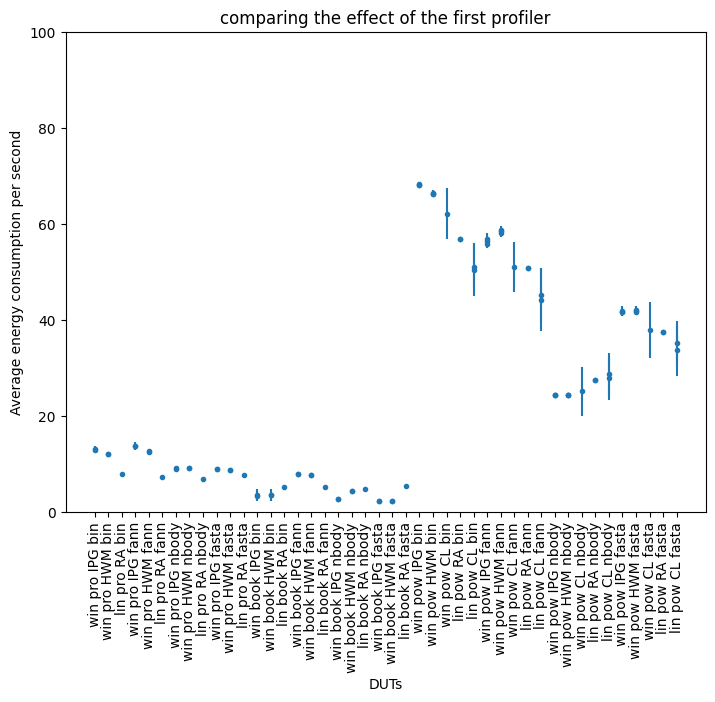

In [440]:
plot_first_profiler_comparison(CORE_TOTAL, data, dynamic_energy, "DUTs", "Average energy consumption per second", "comparing the effect of the first profiler", ylim_max=100)

In [441]:
def get_iteration():
    for i in range(30):
        yield i
        
def is_correct_iteration(exp, value):
    return exp.iteration == value

### How time passed since a restart effects energy consumptionn

A graph presenting the relationship between the iteration since a system restart, and how it affects the energy consumption

['Fasta']
PowerKomplett - Fasta - Win32NT - IntelPowerGadget - avg 4.275862068965517 (4, 5)
PowerKomplett - Fasta - Win32NT - HardwareMonitor - avg 4.241379310344827 (3, 5)
PowerKomplett - Fasta - Win32NT - Clamp - avg 3.793103448275862 (2, 4)
PowerKomplett - Fasta - Unix - RAPL - avg 3.689655172413793 (2, 4)
PowerKomplett - Fasta - Unix - Clamp - avg 3.8275862068965516 (2, 4)


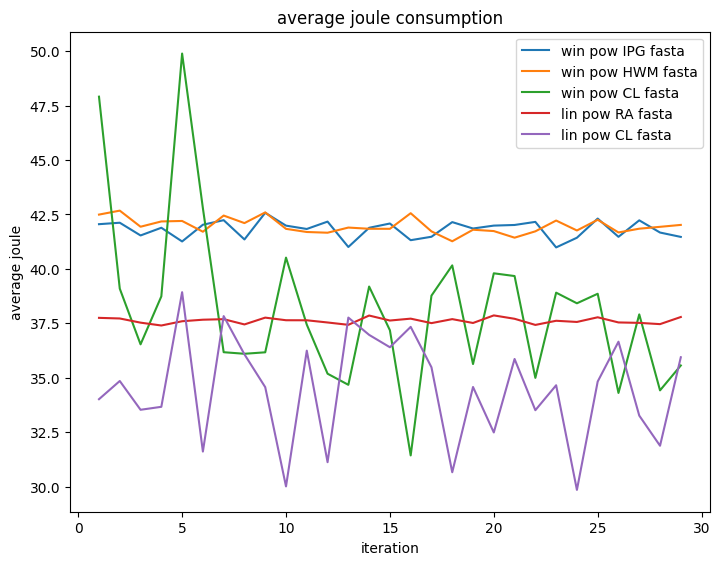

['Fasta']


In [442]:
used_duts = [POWER_KOMPLETT]
used_test_cases = [FASTA]

plot_iterations(CORE_TOTAL,
                get_iteration,
                is_correct_iteration,
                "iteration",
                "average joule",
                "average joule consumption",
                data,
                dynamic_energy,
                used_duts=used_duts,
                used_test_cases = used_test_cases,
                get_dynamic=True)

print(used_test_cases)

In [443]:
def get_buckets():
    min_bucket = 0
    max_bucket = 100
    bucket_size = 5

    last_value = 0

    for i in range(min_bucket + bucket_size, max_bucket + 1, bucket_size):
        # print(f"min: {last_value}, max: {i}, between: {((i - last_value) / 2) + last_value}")
        yield (last_value, i)
        last_value = i

def is_correct_temperature(exp, value):
    min_value = value[0]
    max_value = value[1]
    
    temp = [x.value for x in exp.start_temperature.data]
    
    avg_temp = sum(temp) / len(temp)
    
    return avg_temp > min_value and avg_temp < max_value

### Temperatures levels effect on energy consumption

A graph presenting the relationship between the temperature and energy consumption

['Fasta']
PowerKomplett - Fasta - Win32NT - IntelPowerGadget - avg 42.0 (11, 102)
PowerKomplett - Fasta - Win32NT - HardwareMonitor - avg 31.0 (3, 97)
PowerKomplett - Fasta - Win32NT - Clamp - avg 19.0 (1, 104)
PowerKomplett - Fasta - Unix - RAPL - avg 40.0 (7, 73)
PowerKomplett - Fasta - Unix - Clamp - avg 26.0 (1, 97)


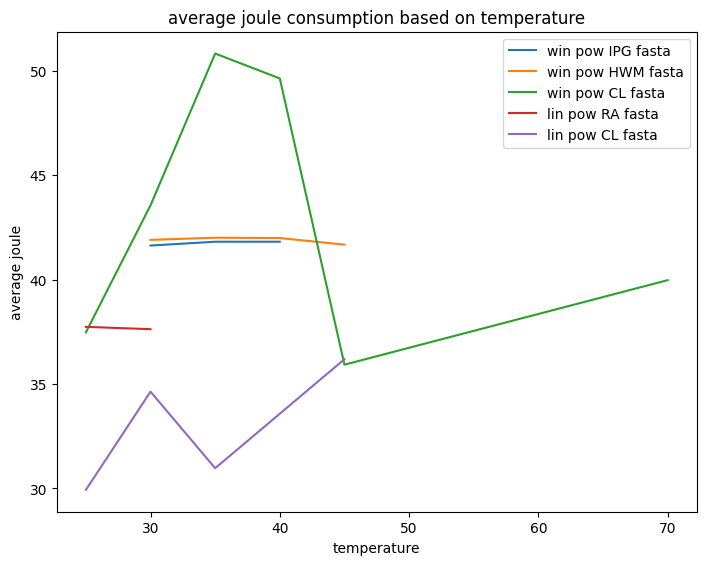

([[30, 35, 40],
  [30, 35, 40, 45],
  [25, 30, 35, 40, 45, 70],
  [25, 30],
  [25, 30, 35, 45]],
 [[41.63618692229814, 41.818575621724385, 41.81977817444066],
  [41.908041307247714,
   42.01102634137908,
   41.995361584970965,
   41.679595272226784],
  [37.47406429965869,
   43.56300460758454,
   50.83381938471432,
   49.64095186976952,
   35.929884708328046,
   39.9788796762698],
  [37.74186025238441, 37.62903495438526],
  [29.930600189800934,
   34.63666903295826,
   30.970139594222644,
   36.1913341954803]],
 ['workstation - IntelPowerGadget',
  'workstation - HardwareMonitor',
  'workstation - Clamp (win)',
  'workstation - RAPL',
  'workstation - Clamp (lin)'])

In [444]:
used_duts = [POWER_KOMPLETT]
used_test_cases = [FASTA]# test_cases

plot_iterations(CORE_TOTAL,
                get_buckets,
                is_correct_temperature,
                "temperature",
                "average joule",
                "average joule consumption based on temperature",
                data,
                dynamic_energy,
                used_duts=used_duts,
                used_test_cases=used_test_cases)

In [445]:
def is_correct_charge(exp, value):
    min_value = value[0]
    max_value = value[1]
    
    temp = [x.value for x in exp.start_battery.data]
    
    if len(temp) == 0:
        return False
    
    avg_temp = sum(temp) / len(temp)
    
    return avg_temp >= min_value and avg_temp < max_value

### Battery levels effect on energy consumption

A graph presenting the relationship between the battery level and energy consumption

['Fasta']
Surface4Pro - Fasta - Win32NT - IntelPowerGadget - avg 14.88888888888889 (6, 18)
Surface4Pro - Fasta - Win32NT - HardwareMonitor - avg 15.0 (6, 18)
Surface4Pro - Fasta - Unix - RAPL - avg 14.5 (3, 19)


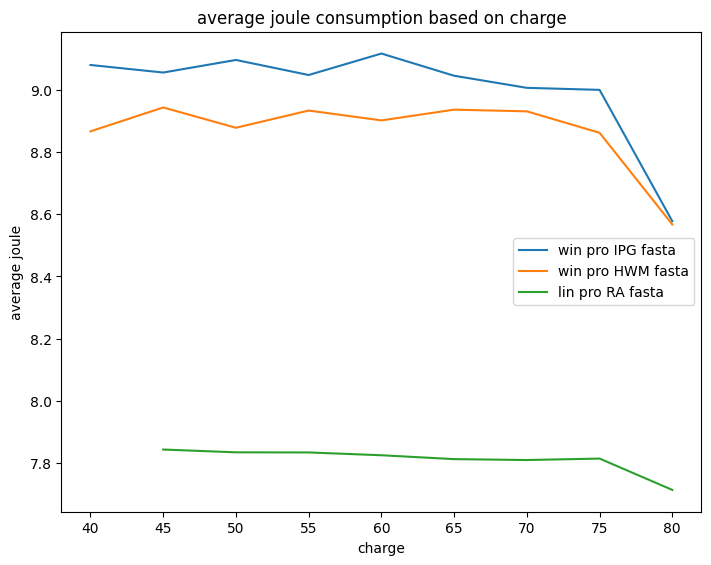

([[40, 45, 50, 55, 60, 65, 70, 75, 80],
  [40, 45, 50, 55, 60, 65, 70, 75, 80],
  [45, 50, 55, 60, 65, 70, 75, 80]],
 [[9.080317639771367,
   9.056028700892501,
   9.096503887014311,
   9.048068406397281,
   9.117130820675587,
   9.045692708379416,
   9.006755519218176,
   9.000236953864679,
   8.577650960792491],
  [8.866856788873834,
   8.943614804680493,
   8.878338892427502,
   8.93372087824597,
   8.901989175752718,
   8.936604655382432,
   8.93115572015441,
   8.862165122986847,
   8.567210711115008],
  [7.842994554210327,
   7.8340217816761095,
   7.833633553314331,
   7.824605336289419,
   7.812161642443131,
   7.809221078417124,
   7.813903060498174,
   7.713118039033552]],
 ['Surface4Pro - IntelPowerGadget',
  'Surface4Pro - HardwareMonitor',
  'Surface4Pro - RAPL'])

In [446]:
used_duts = [SURFACE_4_PRO]
used_test_cases = [FASTA] #test_cases

plot_iterations(CORE_TOTAL,
                get_buckets,
                is_correct_charge,
                "charge",
                "average joule",
                "average joule consumption based on charge",
                data,
                dynamic_energy,
                used_duts=used_duts,
                used_test_cases=used_test_cases)


In [447]:
intel_power_gadget_data_point = data[SURFACE_4_PRO][WINDOWS_OS][BINARY_TREE][INTEL_POWER_GADGET]["experiment"].experiments[0].time_series.data_point[0]
inspect.getmembers(intel_power_gadget_data_point, lambda a:not(inspect.isroutine(a)))

[('CPUFrequency_0MHz', ' 3200'),
 ('CPUUtilization', '   71.000'),
 ('CumulativeDRAMEnergy_0Joules', '   0.113'),
 ('CumulativeDRAMEnergy_0mWh', '   0.031'),
 ('CumulativeGTEnergy_0Joules', '   0.026'),
 ('CumulativeGTEnergy_0mWh', '   0.007'),
 ('CumulativeIAEnergy_0Joules', '   1.830'),
 ('CumulativeIAEnergy_0mWh', '   0.508'),
 ('CumulativeProcessorEnergy_0Joules', '   2.177'),
 ('CumulativeProcessorEnergy_0mWh', '   0.605'),
 ('DRAMPower_0Watt', '   0.875'),
 ('ElapsedTimesec', '    0.129'),
 ('GTFrequencyMHz', 32),
 ('GTPower_0Watt', '   0.203'),
 ('GTUtilization', '   4.897'),
 ('IAPower_0Watt', '  14.175'),
 ('PackageHot_0', '  0'),
 ('PackagePL1_0Watt', '  25.000'),
 ('PackagePL2_0Watt', '  25.000'),
 ('PackagePL4_0Watt', '  46.000'),
 ('PackageTemperature_0C', ' 68'),
 ('PlatformPsysPL1_0Watt', '  45.000'),
 ('PlatformPsysPL2_0Watt', '  45.000'),
 ('ProcessorPower_0Watt', '  16.871'),
 ('RDTSC', ' 12063536978770'),
 ('SystemTime', '06:49:56:760'),
 ('__class__', utils.objects.

In [448]:
intel_power_gadget_data_point.SystemTime, intel_power_gadget_data_point.CumulativeProcessorEnergy_0Joules

('06:49:56:760', '   2.177')

In [449]:
hardware_monitor_data_point = data[SURFACE_4_PRO][LINUX_OS][BINARY_TREE][RAPL]["experiment"].experiments[0].time_series.data_point[:10]
inspect.getmembers(hardware_monitor_data_point, lambda a:not(inspect.isroutine(a)))

[('__add__', <method-wrapper '__add__' of list object at 0x000001BDB66CF500>),
 ('__class__', list),
 ('__contains__',
  <method-wrapper '__contains__' of list object at 0x000001BDB66CF500>),
 ('__delattr__',
  <method-wrapper '__delattr__' of list object at 0x000001BDB66CF500>),
 ('__delitem__',
  <method-wrapper '__delitem__' of list object at 0x000001BDB66CF500>),
 ('__doc__',
  'Built-in mutable sequence.\n\nIf no argument is given, the constructor creates a new empty list.\nThe argument must be an iterable if specified.'),
 ('__eq__', <method-wrapper '__eq__' of list object at 0x000001BDB66CF500>),
 ('__ge__', <method-wrapper '__ge__' of list object at 0x000001BDB66CF500>),
 ('__getattribute__',
  <method-wrapper '__getattribute__' of list object at 0x000001BDB66CF500>),
 ('__gt__', <method-wrapper '__gt__' of list object at 0x000001BDB66CF500>),
 ('__hash__', None),
 ('__iadd__',
  <method-wrapper '__iadd__' of list object at 0x000001BDB66CF500>),
 ('__imul__',
  <method-wrapper 

In [450]:
# for i in [x for x in data[SURFACE_4_PRO][LINUX_OS][FANNKUCH_REDUX][RAPL]["experiment"].experiments[0].time_series.data_point[:10]]:
#     print(i.Core)
#     # print(i.CoreTotal)
#     print(i.PSys)
#     # print(i.PSysTotal)
#     print(i.PackageZero)
#     # print(i.PackageZeroTotal)
#     print("---")

In [451]:
# hardware_monitor_data_point.time, hardware_monitor_data_point.totalLoad

In [452]:
def plot_timestamp(timestamps, values):
    plt.plot(timestamps,values)
    plt.gcf().autofmt_xdate()
    plt.show()

In [453]:
data[SURFACE_4_PRO][LINUX_OS][BINARY_TREE][RAPL]["experiment"].experiments[0].time_series.data_point[0]

In [522]:
def get_time(x, p):
    if p == INTEL_POWER_GADGET:
        return datetime.strptime(x.SystemTime, "%H:%M:%S:%f")
    elif p == HARDWARE_MONITOR:
        return datetime.strptime(trim_date(x.time), "%Y-%m-%d %H:%M:%S.%f")
    elif p == RAPL:
        return datetime.strptime(trim_date(x.Time), "%Y-%m-%d %H:%M:%S.%f")
    elif p == CLAMP:
        return datetime.strptime(trim_date(x.TimeStamp), "%Y-%m-%d-%H-%M-%S-%f")
    else:
        raise Exception(f"{p} not implemented")

def get_value(x, p):
    if p == INTEL_POWER_GADGET:
        return float(x.ProcessorPower_0Watt)
    elif p == HARDWARE_MONITOR:
        return float(x.cpuPowerPacket)
    elif p == RAPL:
        return float(x.PackageZero) * 10
    elif p == CLAMP:
        return float(x.C1TrueRMSPower) * 10
    else:
        raise Exception(f"{p} not implemented")

def trim_date(date):
    date = date.replace("T", " ")
    date = date.replace("Z", " ")
    return date[:-3]        

def plot_test_case_time_series(d, o, t, p):
    data_points = data[d][o][t][p]["experiment"].experiments[0].time_series.data_point

    timestamps = [get_time(x, p) for x in data_points]
    
    values = []
    last_value = -1
    
    for x in data_points:
        new_value = get_value(x, p)
        
        # if p == RAPL:
        #     if last_value == -1:
        #         last_value = new_value
            
        #     values.append(new_value - last_value)
            
        #     last_value = new_value
        # else:
        values.append(new_value)
        
    
    
    
    # values = [get_value(x, p) for x in data_points]

    plot_timestamp(timestamps, values)
    print(values[:10])

def get_values_for_time_series(d, o, t, p):
    data_point_dict = {}
    
    for exp in data[d][o][t][p]["experiment"].experiments:
        data_points = exp.time_series.data_point
        
        for i in range(len(data_points)):
            new_value = get_value(data_points[i], p)
            
            if not i in data_point_dict:
                data_point_dict[i] = []
            
            data_point_dict[i].append(new_value)
    
    return data_point_dict

In [455]:
# test_case = IDLE_CASE,
test_case = BINARY_TREE
# test_case = FANNKUCH_REDUX,
# test_case = NBODY
# test_case = FASTA

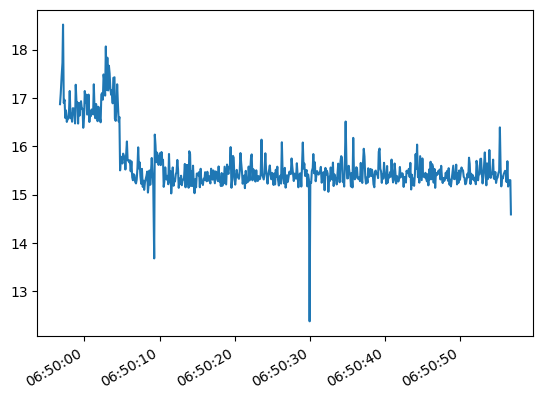

[16.871, 17.082, 17.447, 17.726, 18.517, 16.9, 16.961, 16.586, 16.743, 16.504]


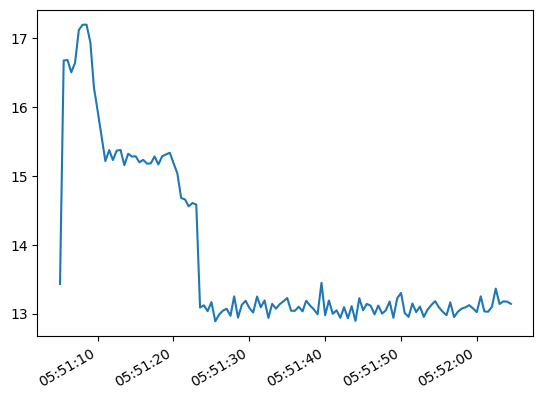

[13.43288, 16.678892, 16.686575, 16.508444, 16.643238, 17.1238, 17.199097, 17.20176, 16.943634, 16.288355]


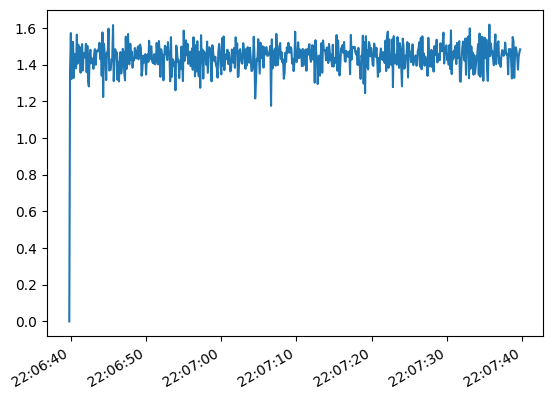

[0.0, 1.361142, 1.572079, 1.321835, 1.517208, 1.524654, 1.327511, 1.457516, 1.433407, 1.380184]


In [456]:
plot_test_case_time_series(SURFACE_4_PRO, WINDOWS_OS, test_case, INTEL_POWER_GADGET)
plot_test_case_time_series(SURFACE_4_PRO, WINDOWS_OS, test_case, HARDWARE_MONITOR)
plot_test_case_time_series(SURFACE_4_PRO, LINUX_OS, test_case, RAPL)

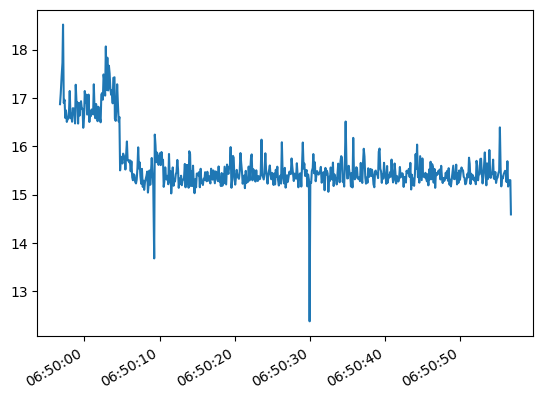

[16.871, 17.082, 17.447, 17.726, 18.517, 16.9, 16.961, 16.586, 16.743, 16.504]


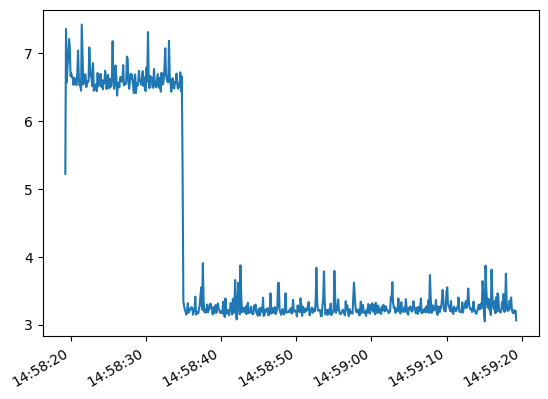

[5.22, 7.354, 6.568, 6.796, 6.95, 7.207, 7.097, 6.66, 6.699, 6.641]


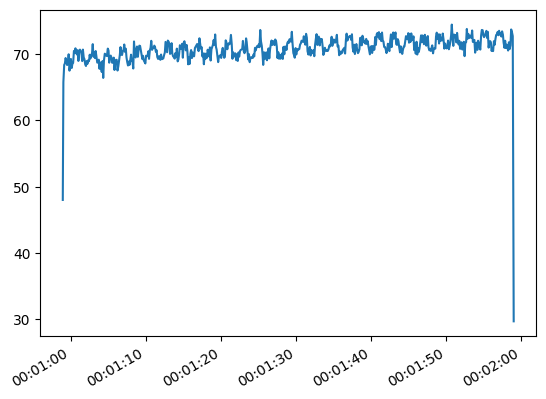

[48.018, 65.786, 68.377, 68.603, 69.419, 68.902, 68.361, 68.697, 69.984, 67.516]


In [457]:
plot_test_case_time_series(SURFACE_4_PRO, WINDOWS_OS, test_case, INTEL_POWER_GADGET)
plot_test_case_time_series(SURFACE_BOOK, WINDOWS_OS, test_case, INTEL_POWER_GADGET)
plot_test_case_time_series(POWER_KOMPLETT, WINDOWS_OS, test_case, INTEL_POWER_GADGET)

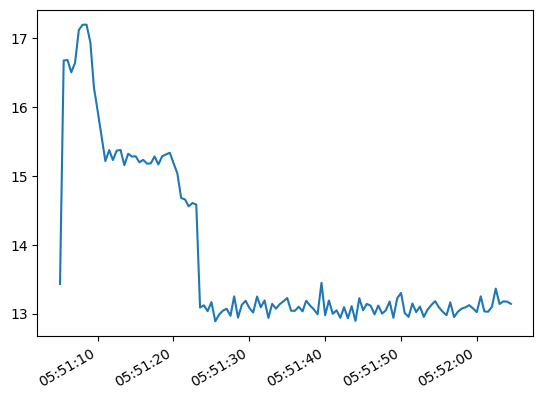

[13.43288, 16.678892, 16.686575, 16.508444, 16.643238, 17.1238, 17.199097, 17.20176, 16.943634, 16.288355]


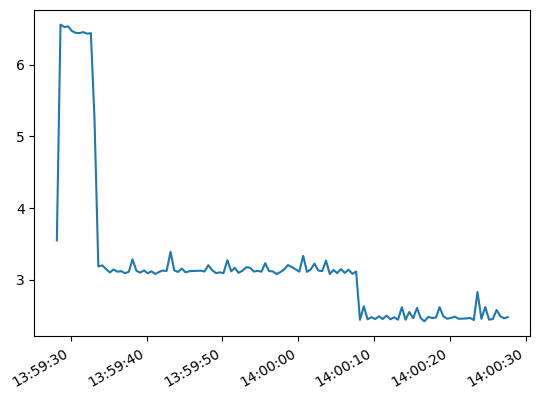

[3.5466135, 6.557426, 6.522956, 6.532194, 6.4668927, 6.4415054, 6.43935, 6.4518867, 6.430913, 6.4378157]


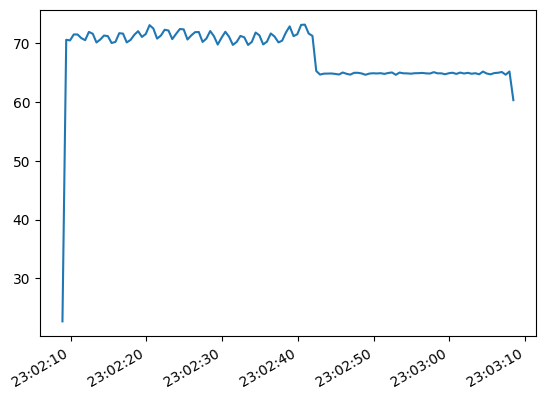

[22.694046, 70.59939, 70.49515, 71.504265, 71.5025, 70.880844, 70.53367, 71.93668, 71.6212, 70.13974]


In [458]:
plot_test_case_time_series(SURFACE_4_PRO, WINDOWS_OS, test_case, HARDWARE_MONITOR)
plot_test_case_time_series(SURFACE_BOOK, WINDOWS_OS, test_case, HARDWARE_MONITOR)
plot_test_case_time_series(POWER_KOMPLETT, WINDOWS_OS, test_case, HARDWARE_MONITOR)

In [459]:
exp = data[SURFACE_BOOK][WINDOWS_OS][FANNKUCH_REDUX][HARDWARE_MONITOR]["experiment"]

In [460]:
inspect.getmembers(exp.experiments[0], lambda a:not(inspect.isroutine(a)))

[('__class__', utils.objects.RawData),
 ('__delattr__',
  <method-wrapper '__delattr__' of RawData object at 0x000001BE546F1390>),
 ('__dict__',
  {'cpuPowerPacketTotalJ': 541.1877729892731,
   'cpuPowerCoresTotalJ': 485.2658758163452,
   'cpuPowerMemoryTotalJ': 42.20328709483147,
   'cpuPowerPacketAverageJ': 4.509898108243942,
   'cpuPowerCoresAverageJ': 4.043882298469543,
   'cpuPowerMemoryAverageJ': 0.3516940591235956,
   'is_valid': True,
   'id': 5307,
   'start_time': datetime.datetime(2022, 11, 20, 3, 46, 3, 74330),
   'end_time': datetime.datetime(2022, 11, 20, 3, 47, 3, 196862),
   'runs': 152677,
   'iteration': 12,
   'first_profiler': 'IntelPowerGadget',
   'duration': 60122,
   'time_series': <utils.objects.TimeSeries at 0x1be546f14e0>,
   'has_time_series': True,
   'start_temperature': <utils.objects.Measurements at 0x1be546f2c50>,
   'stop_temperature': <utils.objects.Measurements at 0x1be546f2ef0>,
   'start_battery': <utils.objects.Measurements at 0x1be546f3190>,
   '

In [461]:
# for o in os:
#     for d in duts:
#         for t in test_cases:
#             for p in profilers:
#                 print(f"{o} - {d} - {t} - {p}")

In [462]:
class ExpDataPoint(object):
    def __init__(self, exp_id, consumption, runs, duration):
        self.exp_id = exp_id
        self.x = consumption/ runs
        self.y = duration / runs
    
    def set_id(self, id):
        self.id = id
    
    def get_tuple(self):
        return (self.x, self.y)

    def set_distance_to_k(self, value):
        self.dist = value

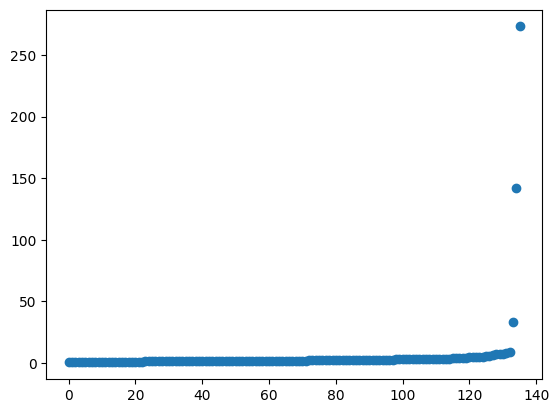

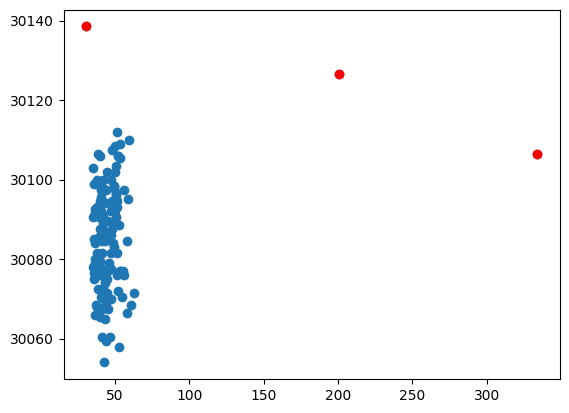

3 points were removed


[2933, 2999, 2664]

In [463]:
o_os = WINDOWS_OS
o_dut = SURFACE_4_PRO
o_test_case = IDLE_CASE
o_profiler = INTEL_POWER_GADGET
#  Win32NT - Surface4Pro - TestCaseIdle - IntelPowerGadget

y_max = 1.1
y_min = 1
x_min = 0
x_max = 0.02

use_x_lim = True
use_y_lim = True

use_x_lim = False
use_y_lim = False


experiments = data[o_dut][o_os][o_test_case][o_profiler]["experiment"].experiments
k = 4
look_back = 6

exp_ids_to_remove = find_outliers(experiments, k, look_back, o_profiler,y_max, y_min, x_min, x_max, use_x_lim, use_y_lim, show_graphs=True)

exp_ids_to_remove

In [464]:
# repository = DataRepository()

In [465]:
# version = dut_version[o_dut][o_os]
# parameters_for_query = (o_dut, o_os, o_test_case, version, o_profiler)
# parameters_for_insert = (k, look_back, o_dut, o_os, o_test_case, version, o_profiler)

# # repository.parameters_exists(parameters_for_query, repository)
# repository.insert_parameters(parameters_for_query, parameters_for_insert, repository)
# repository.get_parameters(parameters_for_query, repository)

In [466]:
import os.path

def write_to_path(save_path, file_name, content):
    with open(os.path.join(save_path,file_name), "w") as file1:
        toFile = content
        file1.write(toFile)

In [467]:
type_map = {
    DRAM_TOTAL : "Dram",
    CORE_TOTAL : "Cores"
}


# for is_dynamic in [True, False]:
#     for include_outliers in [True, False]:
#         for measurement_type in [CORE_TOTAL, DRAM_TOTAL]:
#             for t in test_cases:
#                 used_test_cases = [t]
                
#                 desc = "dynamic energy consumption" if is_dynamic else "energy consumption"
#                 desc_higg = "Dynamic Energy" if is_dynamic else "Energy"
#                 desc_label = "dynamic_energy" if is_dynamic else "energy"
#                 desc_outliers = "with outliers" if include_outliers else "without outliers"
#                 desc_outliers_high = "With Outliers" if include_outliers else "Without Outliers"
#                 desc_out_label = "with_outliers" if include_outliers else "without_outliers"

#                 p25, p75, low_whiskey, high_whiskey, median, names, _, _ = plot_comparison(measurement_type, 
#                                                                                         data, 
#                                                                                         dynamic_energy, 
#                                                                                         "", 
#                                                                                         "", 
#                                                                                         "", 
#                                                                                         get_dynamic=is_dynamic, 
#                                                                                         plot_graph=False, 
#                                                                                         used_test_cases=used_test_cases, 
#                                                                                         include_outliers=include_outliers)
                
#                 plots = ""

#                 for val in zip(low_whiskey, p25, median, p75, high_whiskey):
#                     plots += """
#                             \\addplot+ [boxplot prepared={{
#                             lower whisker={0},
#                             lower quartile={1},
#                             median={2},
#                             upper quartile={3},
#                             upper whisker={4}}},
#                             ] table[row sep=\\\\,y index=0] {{\\\\}};
#                             """.format(val[0], val[1], val[2], val[3], val[4])

#                 xlabel = f"Average {desc} (Watts)"
#                 title = f"{type_map[measurement_type]} - {t} - {desc_higg} - {desc_outliers}"
#                 ytick = str(list(range(1, len(p25)+1))).replace('[', '').replace(']', '')
#                 yticklabels = str(names).replace('[', '').replace(']', '').replace('\'', '')
#                 caption = f"{type_map[measurement_type]} {desc} for test case {t} for all DUT's and OS's ({desc_outliers})"
#                 label = f"{t}_{type_map[measurement_type]}_comparison_{desc_label}_{desc_out_label}_avg_watts"

#                 tex = """
#                 \\begin{{figure}}
#                     \\centering
#                     \\begin{{tikzpicture}}[]
#                         \pgfplotsset{{%
#                             width=.8\\textwidth,
#                             height=1.3\\textwidth
#                         }}
#                         \\begin{{axis}}[xlabel={{{0}}}, title={{{1}}}, ytick={{{2}}},
#                         yticklabels={{
#                             {3}
#                             }},
#                             xmin=0,xmax=80,
#                             ]
#                         {4}
#                         \\end{{axis}}
#                     \\end{{tikzpicture}}
#                 \\caption{{{5}}} \label{{fig:{6}}}
#                 \\end{{figure}}
#                 """

#                 save_path = f"C:/Users/Mads Kusk/git/BiksPower/09th-semester-report/tabels/experiment_results/comparison/{desc_label}/{desc_out_label}/{type_map[measurement_type]}"
#                 Path(save_path).mkdir(parents=True, exist_ok=True)
#                 file_name = f"{t}.tex"
#                 content = "succ"
#                 write_to_path(save_path, file_name, tex.format(xlabel, title, ytick, yticklabels, plots, caption, label))

In [468]:
def plot_average_time_series(d, o, t, p, plot_graph = True):
    values_for_time_series = get_values_for_time_series(d, o, t, p)
    
    data_point_dict_min = {}
    data_point_dict_max = {}
    data_point_dict_avg = {}


    for k in values_for_time_series.keys():
        current_values = values_for_time_series[k]
        
        data_point_dict_min[k] = min(current_values)
        data_point_dict_max[k] = max(current_values)
        data_point_dict_avg[k] = sum(current_values) / len(current_values)
    
    min_data_points_to_plot = [(k, data_point_dict_min[k]) for k in data_point_dict_min.keys()]
    max_data_points_to_plot = [(k, data_point_dict_max[k]) for k in data_point_dict_max.keys()]
    avg_data_points_to_plot = [(k, data_point_dict_avg[k]) for k in data_point_dict_avg.keys()]
    
    if plot_graph:
        plt.plot(*zip(*min_data_points_to_plot))
        plt.plot(*zip(*max_data_points_to_plot))
        plt.plot(*zip(*avg_data_points_to_plot))
    
    return min_data_points_to_plot, max_data_points_to_plot, avg_data_points_to_plot

In [469]:
used_dut = POWER_KOMPLETT
used_os = WINDOWS_OS
used_test_case = FASTA
used_profiler = INTEL_POWER_GADGET

In [506]:
min_data_points_to_plot, max_data_points_to_plot, avg_data_points_to_plot = plot_average_time_series(used_dut, used_os, used_test_case, used_profiler, plot_graph = False)

In [507]:
len(min_data_points_to_plot), len(max_data_points_to_plot), len(avg_data_points_to_plot)

(601, 601, 601)

In [508]:
max_point_x = min_data_points_to_plot[-1][0]

for i in range(len(min_data_points_to_plot)):
    min_data_points_to_plot[i] = (((1/max_point_x) * i) * 60, min_data_points_to_plot[i][1])
    max_data_points_to_plot[i] = (((1/max_point_x) * i) * 60, max_data_points_to_plot[i][1])
    avg_data_points_to_plot[i] = (((1/max_point_x) * i) * 60, avg_data_points_to_plot[i][1])



In [501]:
min_data_points_to_plot[-1], max_data_points_to_plot[-1], avg_data_points_to_plot[-1]

((60.0, 34.087), (60.0, 58.531), (60.0, 42.673784615384605))

In [523]:
for d in duts:
    for o in oses:
        for t in test_cases:
            for p in profilers:
                used_dut = d
                used_os = o
                used_test_case = t
                used_profiler = p
                
                if data[d][o][t][p]["contains_data"]:
                    min_data_points_to_plot, max_data_points_to_plot, avg_data_points_to_plot = plot_average_time_series(used_dut, used_os, used_test_case, used_profiler, plot_graph = False)

                    max_point_x = min_data_points_to_plot[-1][0]

                    for i in range(len(min_data_points_to_plot)):
                        min_data_points_to_plot[i] = (((1/max_point_x) * i) * 60, min_data_points_to_plot[i][1])
                        max_data_points_to_plot[i] = (((1/max_point_x) * i) * 60, max_data_points_to_plot[i][1])
                        avg_data_points_to_plot[i] = (((1/max_point_x) * i) * 60, avg_data_points_to_plot[i][1])

                    x_label = "Time (Seconds)"
                    y_label = "Energy Consumption (Joules)" 
                    avg_values = str(avg_data_points_to_plot).replace("[", "").replace("]", "").replace("), (", ")(")
                    max_values = str(max_data_points_to_plot).replace("[", "").replace("]", "").replace("), (", ")(")
                    min_values = str(min_data_points_to_plot).replace("[", "").replace("]", "").replace("), (", ")(")
                    caption = f"The energy consumption of test case {used_test_case} on {used_dut}, measured by {used_profiler}, with the lines representing the minimum, maximum and average energy consumption"
                    label = f"time_series_{used_test_case}_{used_dut}_{used_profiler}"

                    tex = """
                    \\begin{{figure}}
                        \\centering
                        \\begin{{tikzpicture}}[]
                            \\begin{{axis}}[ymax=120,
                            xlabel={{{0}}},
                            ylabel={{{1}}},
                            ]
                            \\addplot[color=blue, mark=none,] coordinates {{ %% AVG value
                            {2}
                            }};
                            \\addplot[color=blue, mark=none,name path=A] coordinates {{ %% MAX value
                            {3}
                            }};
                            \\addplot[color=blue, mark=none,name path=B] coordinates {{ %% MIN value
                            {4}
                            }};
                            \\addplot [pattern=north east lines,pattern color=red] 
                            fill between [
                                of=A and B,soft clip={{domain=0:800}},
                            ];
                            \\end{{axis}}
                    \\end{{tikzpicture}}
                    \\caption{{{5}}} \label{{fig:{6}}}
                    \\end{{figure}}
                    """

                    save_path = f"C:/Users/Mads Kusk/git/BiksPower/09th-semester-report/tabels/experiment_results/timeseries/{used_dut}/{used_os}/{used_profiler}"
                    Path(save_path).mkdir(parents=True, exist_ok=True)
                    file_name = f"{t}.tex"
                    content = "succ"
                    write_to_path(save_path, file_name, tex.format(x_label, y_label, avg_values, max_values, min_values, caption, label))

False

In [472]:
used_duts = duts
used_test_cases = [FASTA]



In [473]:
[x for x in duts]

['Surface4Pro', 'SurfaceBook', 'PowerKomplett']

In [474]:


line_colors = ["red", "green", "orange", "black", "pink", "blue"]
line_types = ["thick", "dotted", "dashed", "dashdotted"]

color_mapper = {
    INTEL_POWER_GADGET : "red",# "thick",
    HARDWARE_MONITOR : "blue",# "dotted",
    RAPL : "orange",# "dashed",
    E3 : "green",# "dashdotted",
    CLAMP : "black",# "dashdotdotted"
}

style_mapper = {
    SURFACE_4_PRO : "ultra thick", #"red",
    SURFACE_BOOK : "dashdotted", #"blue",
    "workstation" : "densely dashed", #"green"
}

In [475]:
exp_types = [("Runs since restart", "how long ago the DUT was restarted", "iteration", is_correct_iteration, get_iteration, "ymin=0,ymax=70,"),
            ("Start battery level", "the battey level of the DUT", "charge", is_correct_charge, get_buckets, "ymin=0,ymax=20,"),
            ("Start temperature", "the temperature of the DUT", "temperature", is_correct_temperature, get_buckets, "ymin=0,ymax=100,")]

# for include_outliers in [True, False]:
#     for exp_type in exp_types:
#         current_label = exp_type[0] #"Runs since restart"
#         current_desc = exp_type[1]#"how long ago the DUT was restarted"
#         current_name = exp_type[2]#"iteration"
#         current_is_correct = exp_type[3]# is_correct_iteration
#         current_get = exp_type[4]#get_iteration
#         current_min_max = exp_type[5]
#         for measurement_type in [CORE_TOTAL, DRAM_TOTAL]:
#             for t in test_cases:
#                 desc_outliers = "with outliers" if include_outliers else "without outliers"
#                 desc_outliers_high = "With Outliers" if include_outliers else "Without Outliers"
#                 desc_out_label = "with_outliers" if include_outliers else "without_outliers"
                
#                 used_test_cases = [t]
#                 x_lines, y_lines, name_lines = plot_iterations(measurement_type, 
#                                                             current_get, 
#                                                             current_is_correct, 
#                                                             "",
#                                                             "",
#                                                             "",
#                                                             data,
#                                                             dynamic_energy,
#                                                             used_test_cases = used_test_cases, 
#                                                             plot_graph=False,
#                                                             include_outliers=include_outliers
#                                                         )
                
#                 plots = ""
#                 for z in zip(x_lines, y_lines,name_lines):
#                     x = [(x[0], x[1]) for x in zip(z[0], z[1])]
                    
#                     for d in duts:
#                         if d in z[2]:
#                             style = style_mapper[d]
#                             break
#                     for p in profilers:
#                         if p in z[2]:
#                             color = color_mapper[p]
                    
#                     if "workstation" in z[2]:
#                         style = "densely dashed"                
                    
#                     if "(win)" in z[2]:
#                         color = "cyan"

                    
#                     plots += """
#                             \\addplot [mark=none, {0}, {1}]  coordinates {{
#                             {2}
#                             }};
#                             \\addlegendentry{{{3}}}
#                             """.format(style, color, str(x).replace('[', '').replace(']', '').replace('), (', ')('), z[2])
                            
#                 x_label = current_label
#                 y_label = "Average dynamic energy (watt)"
#                 caption = f"A graph illustrating the energy consumption of {type_map[measurement_type]} for test case {t} with regards to {current_desc} ({desc_outliers})"
#                 label = f"{t}_{type_map[measurement_type]}"

#                 tex = """
#                 \\begin{{figure}}
#                     \\centering
#                     \\begin{{tikzpicture}}
#                         \\pgfplotsset{{%
#                             width=1\\textwidth,
#                             height=1\\textheight
#                         }}
#                         \\begin{{axis}}[
#                             xlabel={{{0}}},
#                             ylabel={{{1}}},
#                             {2}
#                         ]
#                         {3}
#                         \\end{{axis}}
#                     \\end{{tikzpicture}} 
#                 \\caption{{{4}}} \label{{fig:{5}}}
#                 \\end{{figure}}
#                 """

#                 save_path = f"C:/Users/Mads Kusk/git/BiksPower/09th-semester-report/tabels/experiment_results/graphs/{current_name}/{desc_out_label}/{type_map[measurement_type]}"
#                 Path(save_path).mkdir(parents=True, exist_ok=True)
#                 file_name = f"{t}.tex"
#                 write_to_path(save_path, file_name, tex.format(x_label, y_label, current_min_max, plots, caption, label))

In [532]:
p25, p75, low_whiskey, high_whiskey, median, _, values, names = plot_comparison(
    CORE_TOTAL, 
    data, 
    dynamic_energy, 
    "core total DUT", 
    "joules in a second", 
    "average core energy consumption in joules for DUTs", 
    ylim_max=100, 
    get_dynamic=False, 
    plot_graph=False, 
    include_idle=True,
    include_outliers=False 
    # used_profilers=[CLAMP]
    )

len(values[0]), len(values)

(133, 55)

In [533]:
results = []

# names = [""]
# values = [[26.62, 26.34, 26.34, 29.36, 26.33]]

for (v, n) in zip(values, names):
    # v = v[:2]
    # v = [round(x, 2) for x in v]
    # print(v)
    m = sum(v) / len(v)
    nom = 0
    
    for i in v:
        nom += (i - m) ** 2
    
    result = nom / len(v)
    
    results.append(result)
    # print(m)
    # print(result)
    
    
    # break
results

stds = [math.sqrt(x) for x in results]


Z = 1.96
E = 0.03

# Z = 2.58
# E = 0.01

n_zeros = []

for (n, s, v) in zip(names, stds, values):
    # v = v[:2]
    if not IDLE_CASE in n:
        n_zero = ((Z ** 2) * (s ** 2)) / (E ** 2)
        sample_size = ((Z ** 2) * s * (1-s)) / (E ** 2)
        n_zeros.append(n_zero)
        
        # print(f"n_0 = {n_zero}, {s}, {n}, {v}")
        # print(f"n_0 = {n_zero}, {s}, {n}, {min(v[:-1])}, {max(v[:-1])}")
        
        # if n_zero > 100:
        #     print("---")
        #     print(v)
        #     print("---")

max(n_zeros), len(n_zeros)



(0.15112791003451786, 44)